In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv("S05-hw-dataset.csv", sep=",")

In [3]:
print("Первые 5 строк:")
print(df.head())
print("\nИнформация о датафрейме:")
print(df.info())
print("\nОписательные статистики:")
print(df.describe())
print("\nРаспределение целевой переменной (default):")
print(df['default'].value_counts(normalize=True))

Первые 5 строк:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.0800

Из представленного первичного анализа данных можно сделать следующие наблюдения:

1. Размер данных: Датасет содержит 3000 объектов (строк) и 17 признаков (столбцов), включая целевой столбец default и технический client_id.

2. Аномалии: Явных аномалий или невозможных значений в данных не обнаружено. Все числовые признаки находятся в ожидаемых и логичных диапазонах: возраст (age) от 21 до 69 лет, соотношение долга к доходу (debt_to_income) в пределах от 0 до 1, баланс счёта (checking_balance) может быть отрицательным. Пропущенных значений нет.

3. Распределение целевой переменной: Задача умеренно несбалансирована. Класс "0" (клиент без дефолта) составляет около 59%, а класс "1" (дефолт) — около 41%. Это не экстремальный перекос, но его стоит учитывать при выборе метрик и интерпретации результатов модели.

In [4]:
X = df.drop(columns=['default', 'client_id'])
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 20% данных в тестовую выборку
    random_state=42,        # Для воспроизводимости
    stratify=y              # Сохраняет распределение классов в сплитах
)
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (2400, 15)
Размер тестовой выборки: (600, 15)


In [5]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_dummy = dummy_clf.predict(X_test)
# Для ROC-AUC нужны вероятности
y_pred_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

# Оценка бейзлайна
dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
dummy_roc_auc = roc_auc_score(y_test, y_pred_proba_dummy)

print(f"DummyClassifier (Most Frequent) Results:")
print(f"Accuracy: {dummy_accuracy:.4f}")
print(f"ROC-AUC: {dummy_roc_auc:.4f}")


DummyClassifier (Most Frequent) Results:
Accuracy: 0.5900
ROC-AUC: 0.5000


In [6]:
logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),          # Стандартизация признаков
    ('classifier', LogisticRegression(     # Логистическая регрессия
        solver='liblinear',
        max_iter=1000,                     # Гарантия сходимости
        random_state=42
    ))
])

In [7]:
# 2. Подбор гиперпараметра C (сила регуляризации) с помощью GridSearchCV
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

grid_search = GridSearchCV(
    logreg_pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print(f"Лучший гиперпараметр C: {grid_search.best_params_['classifier__C']}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

Лучший гиперпараметр C: 20
Лучший ROC-AUC на кросс-валидации: 0.8607


In [8]:
best_logreg = grid_search.best_estimator_
y_pred_logreg = best_logreg.predict(X_test)
y_pred_proba_logreg = best_logreg.predict_proba(X_test)[:, 1]

logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)

print(f"Logistic Regression (Best Model) Test Results:")
print(f"Accuracy: {logreg_accuracy:.4f}")
print(f"ROC-AUC: {logreg_roc_auc:.4f}")

Logistic Regression (Best Model) Test Results:
Accuracy: 0.8000
ROC-AUC: 0.8757


                Model  Accuracy  ROC-AUC
0     DummyClassifier      0.59  0.50000
1  LogisticRegression      0.80  0.87566


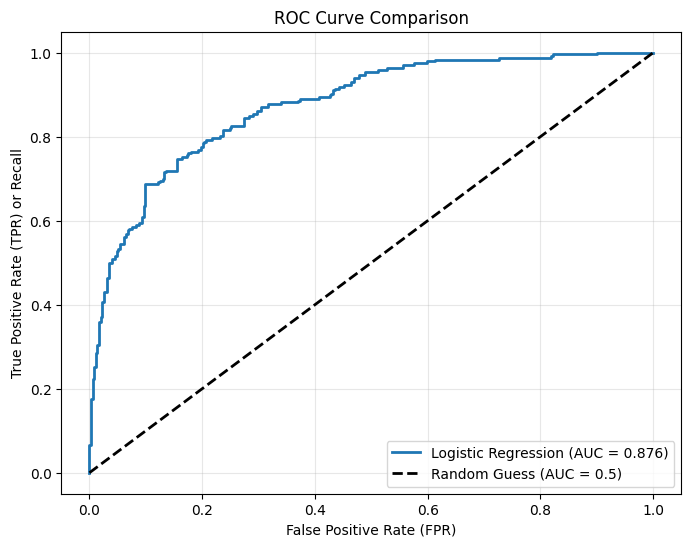

In [9]:
# 1. Создание таблицы сравнения
results_df = pd.DataFrame({
    'Model': ['DummyClassifier', 'LogisticRegression'],
    'Accuracy': [dummy_accuracy, logreg_accuracy],
    'ROC-AUC': [dummy_roc_auc, logreg_roc_auc]
})
print(results_df)

# 2. Построение ROC-кривой для логистической регрессии
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_logreg)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {logreg_roc_auc:.3f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)', lw=2)
# Добавим точку для DummyClassifier (его FPR и TPR совпадают для 'most_frequent')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 3. Сохранение графика в папку figures
plt.savefig('figures/roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### **Краткий отчет по результатам эксперимента**

**1. Сравнение бейзлайна и логистической регрессии:** Бейзлайн-модель (DummyClassifier), предсказывающая самый частый класс (отсутствие дефолта), показывает точность 59%, что соответствует доле класса "0" в выборке. Её ROC-AUC = 0.5 — это уровень случайного угадывания, подтверждающий, что модель не обладает дискриминирующей способностью. Логистическая регрессия значительно превосходит бейзлайн по обеим метрикам, демонстрируя способность осмысленно разделять клиентов на основе их признаков.

**2. Рост метрик:** По сравнению с бейзлайном, логистическая регрессия улучшила **accuracy на 21 процентный пункт** (с 59% до 80%). Более показательный рост наблюдается у **ROC-AUC, который увеличился на 0.3757** (с 0.5 до 0.8757). Это указывает на то, что модель не просто чаще угадывает, но и качественно ранжирует клиентов по вероятности дефолта.

**3. Влияние регуляризации (параметра C):** Лучшее значение гиперпараметра C=20, найденное в результате перебора, указывает на то, что для данной задачи и набора признаков оптимальной оказалась **сравнительно слабая регуляризация**. Это означает, что модель смогла использовать сложные взаимосвязи в данных, не столкнувшись с сильным переобучением. Можно предположить, что при более высоких значениях C (например, 100) качество стабилизировалось или начало снижаться на валидации.

**4. Выводы:**
*   **Логистическая регрессия является разумным выбором для этой задачи.** Она показала высокое и стабильное качество (ROC-AUC ~0.87 на тесте) и обладает хорошей интерпретируемостью, что важно для финансовой сферы.
*   **Модель обладает практической полезностью.** Её способность ранжировать клиентов по риску (высокий ROC-AUC) позволяет банку выстраивать приоритеты при проверке заявок или назначать дифференцированные условия кредитования.
*   **Для принятия бизнес-решений необходима дальнейшая настройка.** Хотя общая точность (accuracy) возросла, для кредитного скоринга критически важны метрики precision (точность предсказания дефолтов) и recall (полнота выявления дефолтов). Следует проанализировать компромисс между этими метриками и выбрать оптимальный порог срабатывания модели, исходя из стоимости ошибок для банка (например, риск выдать "плохой" кредит vs. риск отказать "хорошему" клиенту).